# YOLO - OBB

En el otro *notebook*, hemos visto cómo se puede entrenar un YOLO para realitzar detección de objetos en el dataset Indoor. Hemos podido analizar los diferentes tipos de freezing y cómo afectan al resultado final del modelo.

Aún así, quería experimentar un poco más con este tipo de modelos.

En classe, en general la detección de objetos vista ha sido la más "simple": Bounding boxes horizontales. Existe otro tipo de detección de objetos dónde no sólo nos interesa saber dónde está el objeto sinó también su dirección: Oriented Detection.

![alt text](download.jpg)

Este tipo de detección es particularmente rellevante para imágenes de satélite. Existe una versión preentrenada de YOLO para realizar esta tarea, los yolo - obb. https://docs.ultralytics.com/tasks/obb/#visual-samples

Estos modelos estan preentrenados en el dataset DOTAv1. Para observar cómo se comportan estos modelos con un nuevo dataset, se ha escogido otro dataset similar, aunque ligeramente diferente: el dataset DIOR (fué el primero que encontré con un tamaño "adecuado")
Se puede descargar en: https://drive.google.com/drive/folders/1UdlgHk49iu6WpcJ5467iT-UqNPpx__CC

La principal diferencia al entrenar esta nueva tarea (detección + orientación) es que el formato de las labels en este caso debe ser:

```
class_index x1 y1 x2 y2 x3 y3 x4 y4
```

Nuestro dataset tiene aproximadamente 5500 imágenes de train, 5500 de val y 11000 de test. Contiene anotaciones tanto para HBB como OBB, así que también se podría utilitzar cómo el dataset anterior para predecir bounding boxes "normales".

## Librerías e installs

In [ ]:
!pip install matplotlib ultralytics scikit-learn

In [ ]:
!sudo apt update
!sudo apt install -y libgl1

In [ ]:
import os
import shutil
import zipfile
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from PIL import Image
from tqdm.notebook import tqdm  # For progress bars
from ultralytics import YOLO
import cv2 # For image reading
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, average_precision_score
import xml.etree.ElementTree as ET
from collections import defaultdict
from ultralytics import settings

## Funciones para processar el dataset

YOLO requiere un formato muy específico de organización de carpetas y etiquetas:

![alt text](datasetDir.png)

Las funciones definidas a continuación nos permiten pasar de la estructura de carpetas de DINO (annotations, JPEGImages-trainval, JPEGImages-test) a esta.

In [98]:
def prepare_dior_dataset(dataset_dir, output_dir, train=True):
    """Preparamos el dataset DIOR en el formato que YOLO quiere"""
    train_dir = os.path.join(output_dir, "train") # Creamos las carpetas necesarias
    val_dir = os.path.join(output_dir, "val")
    test_dir = os.path.join(output_dir, "test")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    train_images_dir = os.path.join(train_dir, "images")
    train_labels_dir = os.path.join(train_dir, "labels")
    val_images_dir = os.path.join(val_dir, "images")
    val_labels_dir = os.path.join(val_dir, "labels")
    test_images_dir = os.path.join(test_dir, "images")
    test_labels_dir = os.path.join(test_dir, "labels")

    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)

    # Nombres de las 20 classes de DIOR
    class_names = ['airplane', 'airport', 'baseballfield', 'basketballcourt', 'bridge', 'chimney', 'dam', 'Expressway-Service-area', 'Expressway-toll-station', 'golffield', 'groundtrackfield', 'harbor', 'overpass', 'ship', 'stadium', 'storagetank', 'tenniscourt', 'trainstation', 'vehicle', 'windmill']
    class_mapping = {name: i for i, name in enumerate(class_names)}

    def process_images_and_labels(image_files, images_dir, labels_dir, oimages_dir, olabels_dir):
        for image_file in tqdm(image_files, desc=f"Processing Images to {images_dir}"):
            image_path = os.path.join(oimages_dir, image_file)
            xml_path = os.path.join(olabels_dir, image_file.replace(".jpg", ".xml"))

            if os.path.exists(xml_path): # Las labels estan en formato xml, y queremos pasarlas a .txt.
                tree = ET.parse(xml_path)
                root = tree.getroot() # Parseamos el xml

                label_path = os.path.join(labels_dir, image_file.replace(".jpg", ".txt"))

                with open(label_path, "w") as label_file:
                    for obj in root.findall('object'): # Cada uno de los objetos de la imagen está en un tag object
                        class_name = obj.find('name').text
                        if class_name in class_mapping:
                            class_id = class_mapping[class_name]
                            robndbox = obj.find('robndbox')
                            x1 = int(robndbox.find('x_left_top').text) / 800 # 800 es el tamaño de la imagen. YOLO quiere las coordenadas normalizadas para entrenar
                            y1 = int(robndbox.find('y_left_top').text) / 800
                            x2 = int(robndbox.find('x_right_top').text) / 800
                            y2 = int(robndbox.find('y_right_top').text) / 800
                            x3 = int(robndbox.find('x_right_bottom').text) / 800
                            y3 = int(robndbox.find('y_right_bottom').text) / 800
                            x4 = int(robndbox.find('x_left_bottom').text) / 800
                            y4 = int(robndbox.find('y_left_bottom').text) / 800

                            if x1 > 1:
                                print("somethings wrong") # A veces ocurre que hay bounding boxes fuera del tamaño de la imagen. YOLO simplemente te pone un warning así que tampoco es un gran problema.
                                print(f"{class_id} {x1} {y1} {x2} {y2} {x3} {y3} {x4} {y4}\n")

                            label_file.write(f"{class_id} {x1} {y1} {x2} {y2} {x3} {y3} {x4} {y4}\n")
            shutil.copy(image_path, os.path.join(images_dir, image_file))
            
    if train:
        # Procesamos las imágenes de trainval
        trainval_images_dir = os.path.join(dataset_dir, "JPEGImages-trainval")
        trainval_labels_dir = os.path.join(dataset_dir, "Annotations", "Oriented Bounding Boxes")
    
        image_files = [f for f in os.listdir(trainval_images_dir) if f.endswith(".jpg")]
        # random.shuffle(image_files)  # No shuffleamos para que train y val sea lo correcto
    
        split_index = 5863 # El tamaño de train iba en un fichero de DINO
        train_files = image_files[:split_index]
        val_files = image_files[split_index:]

   

        process_images_and_labels(train_files, train_images_dir, train_labels_dir, trainval_images_dir, trainval_labels_dir)
        process_images_and_labels(val_files, val_images_dir, val_labels_dir,trainval_images_dir, trainval_labels_dir)
    
        print("DIOR dataset prepared.")
        return train_dir, val_dir, class_mapping
    else:
        # Más adelante vamos a querer hacer test. Para ello, necessitaremos procesar también estos datos (y modificar el yaml para hacerle creer que el test són los datos de validation)
        otest_images_dir = os.path.join(dataset_dir, "JPEGImages-test")
        otest_labels_dir = os.path.join(dataset_dir, "Annotations", "Oriented Bounding Boxes")
    
        test_files = [f for f in os.listdir(otest_images_dir) if f.endswith(".jpg")]
        process_images_and_labels(test_files, test_images_dir, test_labels_dir, otest_images_dir, otest_labels_dir)
        print("DIOR dataset prepared.")
        return test_dir, class_mapping

def create_data_yaml(train_dir, val_dir, class_names, output_path):
    """YOLO tambien quiere un yaml con info sobre las clases y cómo esta repartido el dataset"""
    data_yaml = {
        "train": os.path.join(train_dir.replace("datasets/", ""), "images"),
        "val": os.path.join(val_dir.replace("datasets/", ""), "images"),
        "nc": len(class_names),
        "names": list(class_names.keys()),
    }
    with open(output_path, "w") as f:
        yaml.dump(data_yaml, f, default_flow_style=False)
    print("data.yaml created.")

## Funciones para entrenar y usar el modelo

Muchas son wrappers de métodos de la classe YOLO (.train y .val). Internamente la librería ya guarda muchos outputs y resultados 

In [5]:
def load_model(model_type = 'yolov8n-obb.pt'):
    """
    Nos permite cargar un modelo de YOLO. Lo descarga solo :)
    Si queremos usar un modelo NO preentrenado, sería en vez de .pt, usar .yaml.
    """
    try:
        model = YOLO(model_type)
    except Exception as e:
       print(f'Error loading {model_type}. Make sure the model is downloaded')
       return None 
    return model

In [86]:
def train_model(model, data_yaml_path, epochs=10, imgsz=800, freeze_layers=None):
    """Entrenar un modelo de YOLO (+ freezear lo que queramos)"""
    freeze_num = None
    if freeze_layers:
        if freeze_layers == 'all':
            freeze = [f"model.{x}." for x in range(22)]
            freeze_num = 22 # Tiene 22 capas, esto freezea todo menos la última
        elif freeze_layers == 'backbone':
            freeze = [f"model.{x}." for x in range(10)]
            freeze_num = 10 # El backbone llega hasta la capa 10
        else:
            freeze = []
            freeze_num = None
            
        """
        for k, v in model.named_parameters(): # Internamente hace esto, pero si lo hacemos aquí no funciona 
            # A hacer .train, YOLO cambia a que todo use grad. Para freezear lo correcto es pasar el parámetro freeeze
            v.requires_grad = True
            if any(x in k for x in freeze):
                print(f"freezing {k}")
                v.requires_grad = False
        """

    start_time = time.time()
    model.train(data=data_yaml_path, epochs=epochs, imgsz=imgsz, workers= 0, freeze = freeze_num)
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds.")
    return model, training_time

def evaluate_model(model, val_dir, imgsz = 720, conf=0.25, iou = 0.6):
  """Evalúa el modelo de yolo."""
  print("Running model evaluation...")
  metrics = model.val(imgsz=imgsz, conf=conf, iou= iou) # No hace falta pasar el directorio ni nada: lo recuerda
  print("Model evaluated.")
  
  return metrics

def perform_inference(model, image_paths, output_dir, class_names):
    """Realiza inferencia y plotea las bounding boxes."""
    print("Performing inference...")
    os.makedirs(output_dir, exist_ok=True)

    for image_path in tqdm(image_paths, desc="Inference on images"):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = model(image_path) # Para inferenca sólo hace falta pasarle el path de la imagen

        annotated_image = image.copy()
        i = 0
        for *xyxy, conf, class_id in results[0].obb.data.tolist(): # Results es un objeto de la classe de ultralytics
            #x1, y1, x2, y2 = map(int, xyxy)
            xyxy = results[0].obb.xyxyxyxy.cpu().numpy()[i] # las bounding boxes de OBB tienen un formato diferente (necesitan las 4 esquinas)
            i+=1

            label = class_names[int(class_id)] # Tenemos classe (label)
            confidence = float(conf) # Y confidence

            points = np.array(xyxy, dtype=np.int32).reshape(4, 2)
            cv2.polylines(annotated_image, [points], isClosed=True, color=(0, 255, 0), thickness=2) # Dibujamos lineas entre los puntos
            cv2.putText(annotated_image, f'{label}: {confidence:.2f}', (int(xyxy[0][0]), int(xyxy[0][1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        output_path = os.path.join(output_dir, f"annotated_{os.path.basename(image_path)}")
        cv2.imwrite(output_path, cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

    print("Inference complete. Annotated images are saved in the output directory")


def get_assigned_images_paths(dataset_dir, num_images=3):
    """3 imágenes random del test. Al ser de test, no las ha visto"""
    test_images_dir = os.path.join(dataset_dir, "JPEGImages-test")
    image_files = [f for f in os.listdir(test_images_dir) if f.endswith(".jpg")]
    selected_images = random.sample(image_files, num_images)
    return [os.path.join(test_images_dir, image_file) for image_file in selected_images]

def plot_image(image_path):
    """Auxiliar para plotear imágenes"""
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


## Train

Primero cargamos el dataset y usámos las funciones para procesarlo

In [26]:
output_base_dir = "datasets"
dataset_dir = os.path.join(output_base_dir, "dior_dataset")  # Update with the correct path to your DIOR dataset
settings.update({'datasets_dir': os.path.abspath(output_base_dir)})

In [35]:
# Creamos el data.yaml
train_dir, val_dir, class_mapping = prepare_dior_dataset(dataset_dir, output_base_dir)

data_yaml_path = os.path.join('/workspace/', output_base_dir, "data.yaml")
create_data_yaml(train_dir, val_dir, class_mapping, data_yaml_path)

Processing Images to datasets/train/images:   0%|          | 0/5863 [00:00<?, ?it/s]

Processing Images to datasets/val/images:   0%|          | 0/5862 [00:00<?, ?it/s]

DIOR dataset prepared.
data.yaml created.


Entrenamos el modelo (el output es MUY largo)

In [36]:
# Está pensado para poder buclar diferentes modelos y comparar sus resultados
results = {}
epochs = 10
imgsz = 800

# En el otro notebook hemos visto que freezear el backbone era una buena opción
models = {
    #"Frozen Layers": {"freeze": "all"},
    #"Normal Training": {"freeze": None},
    "Backbone Nano": {"freeze": "backbone", "name": "yolov8n-obb.pt"}, # Nano
    "Backbone Small": {"freeze": "backbone", "name": "yolov8s-obb.pt"} # Small
}

for model_name, config in models.items():
    print(f"--------------- Training with: {model_name} -------------------")
    model = load_model(config["name"])
    if not model: # (aseguramos que esté cargado)
        continue

    trained_model, training_time = train_model(model, data_yaml_path, epochs=epochs, imgsz=imgsz,
                                               freeze_layers=config['freeze'])
    metrics = evaluate_model(trained_model, val_dir, imgsz=imgsz)
    results[model_name] = {
        'metrics': metrics,
        'training_time': training_time,
        'model': trained_model
    }


--------------- Training with: Backbone Nano -------------------
freezing model.model.0.conv.weight
freezing model.model.0.bn.weight
freezing model.model.0.bn.bias
freezing model.model.1.conv.weight
freezing model.model.1.bn.weight
freezing model.model.1.bn.bias
freezing model.model.2.cv1.conv.weight
freezing model.model.2.cv1.bn.weight
freezing model.model.2.cv1.bn.bias
freezing model.model.2.cv2.conv.weight
freezing model.model.2.cv2.bn.weight
freezing model.model.2.cv2.bn.bias
freezing model.model.2.m.0.cv1.conv.weight
freezing model.model.2.m.0.cv1.bn.weight
freezing model.model.2.m.0.cv1.bn.bias
freezing model.model.2.m.0.cv2.conv.weight
freezing model.model.2.m.0.cv2.bn.weight
freezing model.model.2.m.0.cv2.bn.bias
freezing model.model.3.conv.weight
freezing model.model.3.bn.weight
freezing model.model.3.bn.bias
freezing model.model.4.cv1.conv.weight
freezing model.model.4.cv1.bn.weight
freezing model.model.4.cv1.bn.bias
freezing model.model.4.cv2.conv.weight
freezing model.model


train: Scanning /workspace/datasets/train/labels...:   0%|          | 0/5863 [00:00<?, ?it/s]
train: Scanning /workspace/datasets/train/labels... 91 images, 0 backgrounds, 0 corrupt:   2%|▏         | 91/5863 [00:00<00:06, 852.00it/s]
train: Scanning /workspace/datasets/train/labels... 195 images, 0 backgrounds, 2 corrupt:   3%|▎         | 195/5863 [00:00<00:05, 952.48it/s]
train: Scanning /workspace/datasets/train/labels... 291 images, 0 backgrounds, 2 corrupt:   5%|▍         | 291/5863 [00:00<00:05, 939.99it/s]
train: Scanning /workspace/datasets/train/labels... 386 images, 0 backgrounds, 3 corrupt:   7%|▋         | 386/5863 [00:00<00:06, 911.31it/s]
train: Scanning /workspace/datasets/train/labels... 480 images, 0 backgrounds, 5 corrupt:   8%|▊         | 480/5863 [00:00<00:05, 911.67it/s]
train: Scanning /workspace/datasets/train/labels... 572 images, 0 backgrounds, 5 corrupt:  10%|▉         | 572/5863 [00:00<00:05, 914.39it/s]
train: Scanning /workspace/datasets/train/labels... 664

train: WARNING ⚠️ /workspace/datasets/train/images/00107.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.045]
train: WARNING ⚠️ /workspace/datasets/train/images/00133.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0475]
train: WARNING ⚠️ /workspace/datasets/train/images/00366.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0475]
train: WARNING ⚠️ /workspace/datasets/train/images/00419.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.03]
train: WARNING ⚠️ /workspace/datasets/train/images/00433.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0225]
train: WARNING ⚠️ /workspace/datasets/train/images/00740.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.11      1.0675]
train: WARNING ⚠️ /workspace/datasets/train/images/00784.jpg: ignoring corrupt image/lab

train: New cache created: /workspace/datasets/train/labels.cache



val: Scanning /workspace/datasets/val/labels...:   0%|          | 0/5862 [00:00<?, ?it/s]
val: Scanning /workspace/datasets/val/labels... 99 images, 0 backgrounds, 0 corrupt:   2%|▏         | 99/5862 [00:00<00:05, 985.91it/s]
val: Scanning /workspace/datasets/val/labels... 198 images, 0 backgrounds, 0 corrupt:   3%|▎         | 198/5862 [00:00<00:06, 942.13it/s]
val: Scanning /workspace/datasets/val/labels... 293 images, 0 backgrounds, 1 corrupt:   5%|▍         | 293/5862 [00:00<00:06, 914.97it/s]
val: Scanning /workspace/datasets/val/labels... 385 images, 0 backgrounds, 2 corrupt:   7%|▋         | 385/5862 [00:00<00:06, 884.07it/s]
val: Scanning /workspace/datasets/val/labels... 485 images, 0 backgrounds, 2 corrupt:   8%|▊         | 485/5862 [00:00<00:05, 916.02it/s]
val: Scanning /workspace/datasets/val/labels... 578 images, 0 backgrounds, 2 corrupt:  10%|▉         | 578/5862 [00:00<00:05, 913.25it/s]
val: Scanning /workspace/datasets/val/labels... 675 images, 0 backgrounds, 4 corrup

val: WARNING ⚠️ /workspace/datasets/val/images/06149.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.015]
val: WARNING ⚠️ /workspace/datasets/val/images/06185.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0538]
val: WARNING ⚠️ /workspace/datasets/val/images/06446.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0438]
val: WARNING ⚠️ /workspace/datasets/val/images/06480.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.03]
val: WARNING ⚠️ /workspace/datasets/val/images/06587.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0175]
val: WARNING ⚠️ /workspace/datasets/val/images/06886.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0475]
val: WARNING ⚠️ /workspace/datasets/val/images/06973.jpg: ignoring corrupt image/label: non-normalized or out of bounds coor

val: New cache created: /workspace/datasets/val/labels.cache
Plotting labels to runs/obb/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 0 dataloader workers
Logging results to runs/obb/train6
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/362 [00:00<?, ?it/s]
       1/10      5.09G      1.002      5.233      2.429         92        800:   0%|          | 0/362 [00:01<?, ?it/s]
       1/10      5.09G      1.002      5.233      2.429         92        800:   0%|          | 1/362 [00:01<09:52,  1.64s/it]
       1/10      5.09G     0.9614      4.992       2.08        208        800:   0%|          | 1/362 [00:03<09:52,  1.64s/it]
       1/10      5.09G     0.9614      4.992       2.08        208        800:   1%|          | 2/362 [00:03<10:18,  1.72s/it]
       1/10      5.09G       1.03      5.182      2.119         50        800:   1%|          | 2/362 [00:05<10:18,  1.72s/it]
       1/10      5.09G       1.03      5.182      2.119         50        800:   1%|          | 3/362 [00:05<11:09,  1.87s/it]
       1/10      5.09G      0.987      5.149      2.134         85        800:   1%|          | 3/362 [00:07<11:09,  1.87s/it]
       1/10      5.09G      0.987      5.149      2.134         85        800:

                   all       5830      35358      0.641      0.495      0.526      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/362 [00:00<?, ?it/s]
       2/10      1.79G       1.06      1.431      2.068         95        800:   0%|          | 0/362 [00:01<?, ?it/s]
       2/10      1.79G       1.06      1.431      2.068         95        800:   0%|          | 1/362 [00:01<10:03,  1.67s/it]
       2/10      1.79G      1.039      1.545      1.831         67        800:   0%|          | 1/362 [00:03<10:03,  1.67s/it]
       2/10      1.79G      1.039      1.545      1.831         67        800:   1%|          | 2/362 [00:03<10:22,  1.73s/it]
       2/10      2.65G      1.018      1.514      1.726        242        800:   1%|          | 2/362 [00:05<10:22,  1.73s/it]
       2/10      2.65G      1.018      1.514      1.726        242        800:   1%|          | 3/362 [00:05<10:19,  1.73s/it]
       2/10      2.65G     0.9418       1.48      1.871         49        800:   1%|          | 3/362 [00:06<10:19,  1.73s/it]
       2/10      2.65G     0.9418       1.48      1.871         49        800:

In [43]:
# Comparamos (las métricas principales)
print("\n--------------- Analysis and Comparison -------------------\n")
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Training Time: {result['training_time']:.2f} seconds")
    if result['metrics'] is not None:
        print(f"mAP50: {result['metrics'].box.map50:.4f}") # Metrics es un objeto Metrics de la librería de ultralytics
        print(f"mAP50-95: {result['metrics'].box.map:.4f}")
    else:
        print("Evaluation metrics not available")
    print("-------------------------------------")



--------------- Analysis and Comparison -------------------

Model: Backbone Nano
Training Time: 7861.18 seconds
mAP50: 0.7552
mAP50-95: 0.5905
-------------------------------------
Model: Backbone Small
Training Time: 7719.13 seconds
mAP50: 0.7824
mAP50-95: 0.6219
-------------------------------------


## Test

In [89]:
# Seleccionamos 3 imágenes random (para más tarde)
assigned_images_path = get_assigned_images_paths(dataset_dir)
assigned_images_path

['datasets/dior_dataset/JPEGImages-test/16466.jpg',
 'datasets/dior_dataset/JPEGImages-test/13297.jpg',
 'datasets/dior_dataset/JPEGImages-test/18124.jpg']

In [90]:
# Inferencia
inference_output_dir = os.path.join(output_base_dir, "inference_results")
for model_name, result in results.items():
    print(f'\nPerforming inference for model {model_name}...')
    perform_inference(result['model'], assigned_images_path, inference_output_dir, list(class_mapping.keys()))


Performing inference for model Backbone Nano...
Performing inference...


Inference on images:   0%|          | 0/3 [00:00<?, ?it/s]


image 1/1 /workspace/datasets/dior_dataset/JPEGImages-test/16466.jpg: 800x800 13.9ms
Speed: 11.1ms preprocess, 13.9ms inference, 3.8ms postprocess per image at shape (1, 3, 800, 800)
[[     20.663      628.36]
 [     61.534      630.27]
 [     65.675       541.9]
 [     24.804      539.99]]
[[     20.663      628.36]
 [     61.534      630.27]
 [     65.675       541.9]
 [     24.804      539.99]]
[[     431.89      601.61]
 [     473.24      603.38]
 [     477.06      514.62]
 [     435.71      512.85]]
[[     431.89      601.61]
 [     473.24      603.38]
 [     477.06      514.62]
 [     435.71      512.85]]
[[     221.22      638.98]
 [      262.8      641.43]
 [     268.16      550.38]
 [     226.58      547.93]]
[[     221.22      638.98]
 [      262.8      641.43]
 [     268.16      550.38]
 [     226.58      547.93]]
[[     85.591         632]
 [     129.76      634.11]
 [     134.02      545.04]
 [     89.856      542.92]]
[[     85.591         632]
 [     129.76      634.11]

Inference on images:   0%|          | 0/3 [00:00<?, ?it/s]


image 1/1 /workspace/datasets/dior_dataset/JPEGImages-test/16466.jpg: 800x800 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 800, 800)
[[     87.596      632.29]
 [     129.69      634.24]
 [     133.83      545.02]
 [     91.736      543.07]]
[[     87.596      632.29]
 [     129.69      634.24]
 [     133.83      545.02]
 [     91.736      543.07]]
[[     211.95      285.88]
 [     253.38      287.75]
 [     257.42      198.25]
 [     215.99      196.38]]
[[     211.95      285.88]
 [     253.38      287.75]
 [     257.42      198.25]
 [     215.99      196.38]]
[[     287.76      643.61]
 [     332.65      646.13]
 [     337.89      552.98]
 [     292.99      550.46]]
[[     287.76      643.61]
 [     332.65      646.13]
 [     337.89      552.98]
 [     292.99      550.46]]
[[     485.52      605.28]
 [     526.02      606.68]
 [     529.06      518.43]
 [     488.57      517.03]]
[[     485.52      605.28]
 [     526.02      606.68]
 [

Sin esto no ploteaba bien

In [84]:
%matplotlib inline

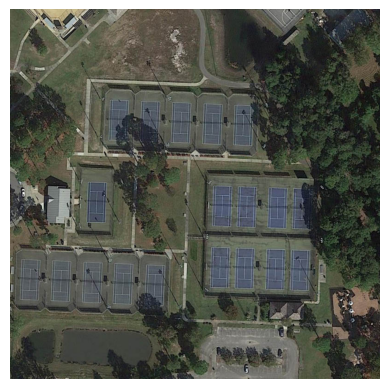

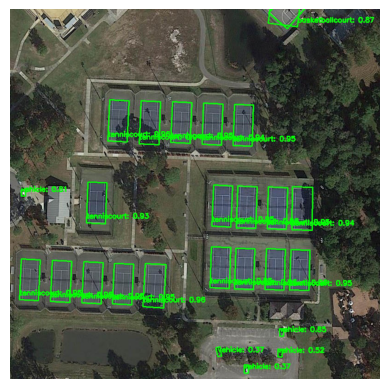

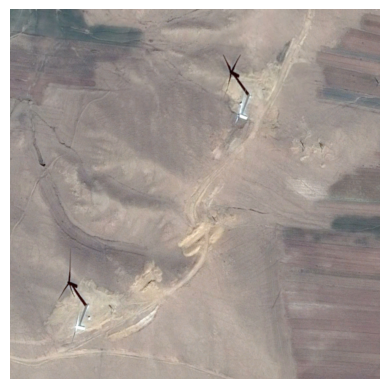

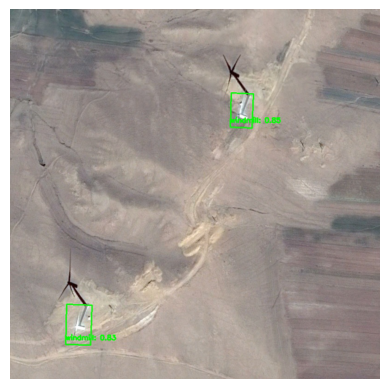

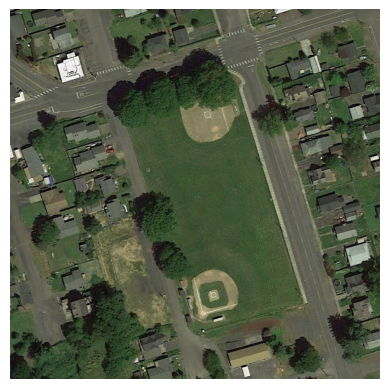

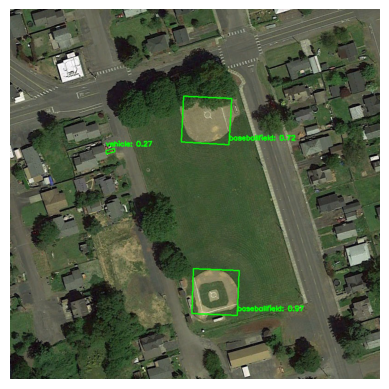


 --------------- END --------------- 



In [91]:
# Mostramos imagenes originales y anotadas
for image_path in assigned_images_path:
    plot_image(image_path)

    annotated_path = os.path.join(inference_output_dir, f"annotated_{os.path.basename(image_path)}")
    plot_image(annotated_path)

print("\n --------------- END --------------- \n")

inverse_class_mapping = {value: key for key, value in class_mapping.items()}

Podemos ver cómo es capaz de identificar con bastante acierto vehículos (aunque sean muy pequeños), pistas de deporte, molinos...

De hecho, hay algun vehículo que me cuesta a mí ver de lo pequeños que són.

Además, estas bounding boxes estan (como era de esperar) orientadas correctamente.

Podemos ver las métricas con todo el test:

In [99]:
test_dir, class_mapping = prepare_dior_dataset(dataset_dir, output_base_dir, train=False)


Processing Images to datasets/test/images:   0%|          | 0/11738 [00:00<?, ?it/s]

DIOR dataset prepared.


In [103]:
test_yaml_path = os.path.join('/workspace/', output_base_dir, "test.yaml")
for model_name, result in results.items():
    print(f'\nPerforming test for model {model_name}...')
    metrics = model.val(data=test_yaml_path, imgsz=imgsz, conf=0.25, iou= 0.5)


Performing test for model Backbone Nano...
Ultralytics 8.3.58 🚀 Python-3.11.9 torch-2.4.0 CUDA:0 (NVIDIA GeForce RTX 4090, 23995MiB)


val: Scanning /workspace/datasets/test/labels... 11738 images, 0 backgrounds, 62 corrupt: 100%|██████████| 11738/11738 [00:13<00:00, 900.05it/s]

val: WARNING ⚠️ /workspace/datasets/test/images/12544.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1163]
val: WARNING ⚠️ /workspace/datasets/test/images/12624.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0738]
val: WARNING ⚠️ /workspace/datasets/test/images/12660.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0013]
val: WARNING ⚠️ /workspace/datasets/test/images/12796.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0175]
val: WARNING ⚠️ /workspace/datasets/test/images/13140.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0575]
val: WARNING ⚠️ /workspace/datasets/test/images/13278.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0125]
val: WARNING ⚠️ /workspace/datasets/test/images/13318.jpg: ignoring corrupt image/label: non-normalized or out of boun

val: New cache created: /workspace/datasets/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 730/730 [05:34<00:00,  2.19it/s]


                   all      11676     123799      0.762      0.636      0.714      0.557
              airplane        701       8154      0.987      0.866       0.93      0.827
               airport        643        652       0.49      0.347      0.407       0.18
         baseballfield       1310       3432      0.957      0.703      0.841      0.794
       basketballcourt        702       2136      0.899      0.908      0.942      0.892
                bridge       1286       2561      0.688      0.412       0.55       0.37
               chimney        447       1031      0.926      0.704      0.837       0.74
                   dam        500        535      0.429      0.355      0.349      0.164
Expressway-Service-area        558       1074      0.821      0.537       0.71      0.507
Expressway-toll-station        634        688      0.704      0.411      0.604      0.551
             golffield        483        567      0.751       0.61      0.716      0.392
      groundtrackfi

val: Scanning /workspace/datasets/test/labels.cache... 11738 images, 0 backgrounds, 62 corrupt: 100%|██████████| 11738/11738 [00:00<?, ?it/s]

val: WARNING ⚠️ /workspace/datasets/test/images/12544.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1163]
val: WARNING ⚠️ /workspace/datasets/test/images/12624.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0738]
val: WARNING ⚠️ /workspace/datasets/test/images/12660.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0013]
val: WARNING ⚠️ /workspace/datasets/test/images/12796.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0175]
val: WARNING ⚠️ /workspace/datasets/test/images/13140.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0575]
val: WARNING ⚠️ /workspace/datasets/test/images/13278.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0125]
val: WARNING ⚠️ /workspace/datasets/test/images/13318.jpg: ignoring corrupt image/label: non-normalized or out of boun


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 730/730 [05:35<00:00,  2.17it/s]


                   all      11676     123799      0.762      0.636      0.714      0.557
              airplane        701       8154      0.987      0.866       0.93      0.827
               airport        643        652       0.49      0.347      0.407       0.18
         baseballfield       1310       3432      0.957      0.703      0.841      0.794
       basketballcourt        702       2136      0.899      0.908      0.942      0.892
                bridge       1286       2561      0.688      0.412       0.55       0.37
               chimney        447       1031      0.926      0.704      0.837       0.74
                   dam        500        535      0.429      0.355      0.349      0.164
Expressway-Service-area        558       1074      0.821      0.537       0.71      0.507
Expressway-toll-station        634        688      0.704      0.411      0.604      0.551
             golffield        483        567      0.751       0.61      0.716      0.392
      groundtrackfi

Métricas del segundo modelo (small)

In [105]:
print("Map50-95: ", metrics.box.map)  # map50-95
print("Map50: ", metrics.box.map50)  # map50
print("Map75: ", metrics.box.map75)  # map75
print("Maps categories: ", metrics.box.maps)  # a list contains map50-95 of each category

Map50-95:  0.5571800740136035
Map50:  0.7136932790788578
Map75:  0.6049987220825792
Maps categories:  [    0.82726      0.1802     0.79404      0.8921     0.36958     0.73957     0.16357     0.50719     0.55104     0.39216     0.63088     0.42914     0.47249     0.81647      0.4006     0.76841     0.91252     0.27484     0.54439     0.47716]


## Comparación entre modelos

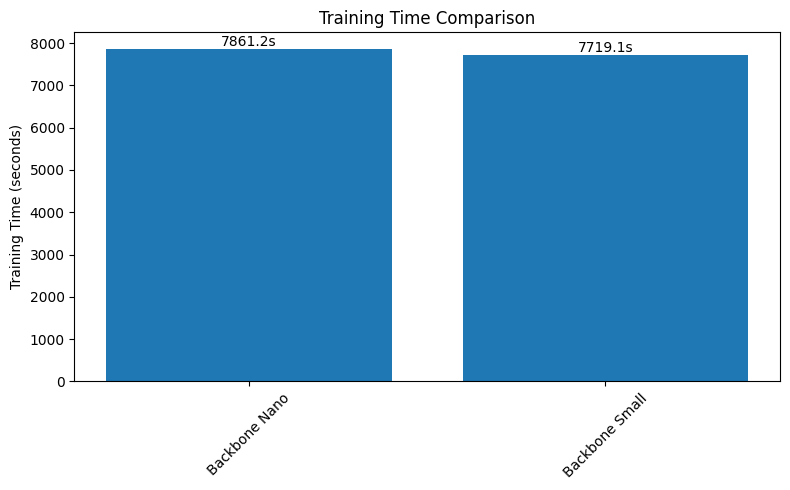

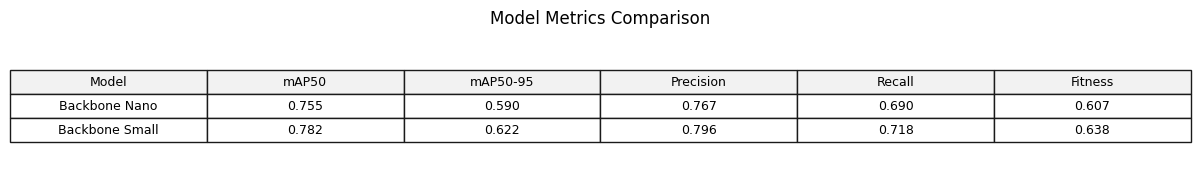

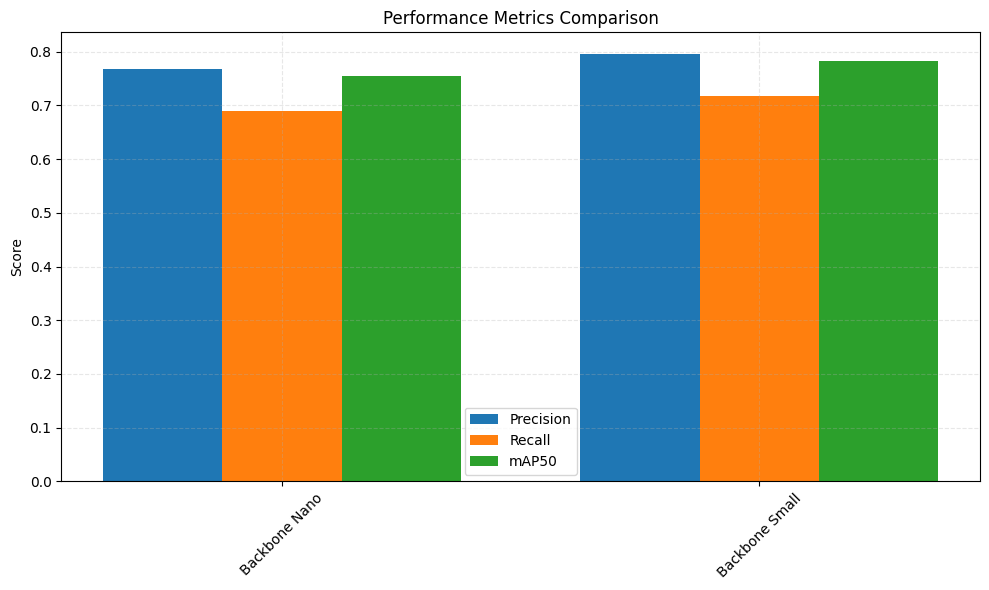

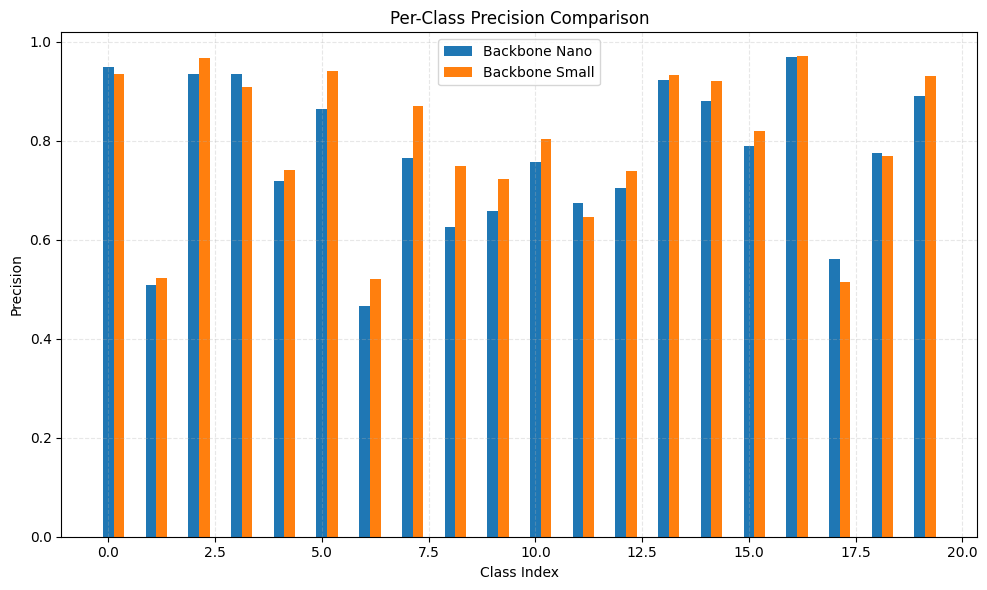

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

def plot_comparative_results(results):
    """
    Compara diversos modelos YOLO
    """
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    colors = sns.color_palette('husl', n_colors=len(results))
    
    # Tiempo
    plt.figure(figsize=(8, 5))
    model_names = list(results.keys())
    training_times = [result['training_time'] for result in results.values()]
    
    bars = plt.bar(model_names, training_times)
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Métricas
    plt.figure(figsize=(12, len(results) * 0.5 + 1))
    metrics_table = []
    headers = ['Model', 'mAP50', 'mAP50-95', 'Precision', 'Recall', 'Fitness']
    
    for model_name, result in results.items():
        metrics = result['metrics']
        results_dict = metrics.results_dict
        metrics_table.append([
            model_name,
            f"{results_dict['metrics/mAP50(B)']:.3f}",
            f"{results_dict['metrics/mAP50-95(B)']:.3f}",
            f"{results_dict['metrics/precision(B)']:.3f}",
            f"{results_dict['metrics/recall(B)']:.3f}",
            f"{metrics.fitness:.3f}"
        ])
    
    table = plt.table(cellText=metrics_table,
                     colLabels=headers,
                     loc='center',
                     cellLoc='center',
                     colColours=['#f2f2f2'] * len(headers))
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    plt.axis('off')
    plt.title('Model Metrics Comparison')
    plt.tight_layout()
    plt.show()
    
    # Bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(model_names))
    width = 0.25
    
    precisions = []
    recalls = []
    map50s = []
    
    for result in results.values():
        metrics = result['metrics']
        results_dict = metrics.results_dict
        precisions.append(results_dict['metrics/precision(B)'])
        recalls.append(results_dict['metrics/recall(B)'])
        map50s.append(results_dict['metrics/mAP50(B)'])
    
    ax.bar(x - width, precisions, width, label='Precision')
    ax.bar(x, recalls, width, label='Recall')
    ax.bar(x + width, map50s, width, label='mAP50')
    
    ax.set_ylabel('Score')
    ax.set_title('Performance Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Por categoría
    if hasattr(next(iter(results.values()))['metrics'].box, 'p'):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        for i, (model_name, result) in enumerate(results.items()):
            metrics = result['metrics']
            class_precisions = metrics.box.p
            
            x_positions = [x + i*width for x in range(len(class_precisions))]
            ax.bar(x_positions, 
                  class_precisions,
                  width,
                  label=model_name)
        
        ax.set_ylabel('Precision')
        ax.set_xlabel('Class Index')
        ax.set_title('Per-Class Precision Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
plot_comparative_results(results)

Sorprendentemente, el tiempo de entrenamiento es muy similar en los dos modelos (caben los dos en GPU, y seguramente haya un bottleneck de datos).

En general, el modelo small tiene un mejor rendimiento, superando al nano en todas las métricas. Un modelo más grande obtendría aún mejor resultados.

In [216]:
# Guardar JSON con resultados (se podía hacer antes con save_json=TRUE)
import json
import numpy as np
from pathlib import Path

def save_results_to_json(results, output_path='model_results.json'):
    json_results = {}
    
    for model_name, result in results.items():
        metrics = result['metrics']
        results_dict = metrics.results_dict
        
        json_results[model_name] = {
            'metrics': {
                'mAP50': float(results_dict['metrics/mAP50(B)']),
                'mAP50-95': float(results_dict['metrics/mAP50-95(B)']),
                'precision': float(results_dict['metrics/precision(B)']),
                'recall': float(results_dict['metrics/recall(B)']),
                'fitness': float(metrics.fitness)
            },
            'training_time': float(result['training_time'])
        }

        if hasattr(metrics, 'curves'):
            curves_data = {}
            i = 0
            for curve_data in metrics.curves:
                if isinstance(curve_data, tuple):
                    curves_data[f"Curve{i}"] = [arr.tolist() for arr in curve_data]
                else:
                    curves_data[f"Curve{i}"] = curve_data
                i += 1
            json_results[model_name]['curves'] = curves_data
        
        if hasattr(metrics.box, 'p'):
            json_results[model_name]['per_class'] = {
                'precision': metrics.box.p.tolist(),
                'recall': metrics.box.r.tolist(),
                'f1': metrics.box.f1.tolist(),
            }
    
    with open(output_path, 'w') as f:
        json.dump(json_results, f, indent=4)
    
    print(f"Results saved to {output_path}")
save_results_to_json(results, 'model_comparison_results.json')

Results saved to model_comparison_results.json


## Resultados

### Val

![alt text](confusion_matrix-2.png)

![alt text](PR_curve-1.png)

![alt text](val_batch0_labels.jpg)

### Test

![alt text](confusion_matrix-3.png)

![alt text](PR_curve-2.png)

![alt text](val_batch2_pred-1.jpg)

Claramente, le cuesta bastante predecir objetos más "abstractos" y seguramente distintos en diferentes lugares, cómo presas, estaciones, puentes... que objetos más pequeños que suelen tener siempre la misma apariencia (coches, aviones, pistas de tenis)

Este dataset y la tarea es más complicado que el Indoor (más clases, y además orientación). Aún así, YOLO predice bastante bien en la mayoría de los casos (aunque sea el YOLO small).